In [1]:
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

sns.set_theme()
pd.options.mode.copy_on_write = True

TRAIN_DATA_FILE_PATH = '../data/green_tripdata_2021-01.parquet'
VAL_DATA_FILE_PATH = '../data/green_tripdata_2021-02.parquet'
MODEL_OUTPUT_PATH = '../models/lin_reg.bin'

In [3]:
import mlflow
from pathlib import Path

home_path_str = Path.home()
backend_store_uri = f'sqlite:///{home_path_str}/mlflow/backend/mlflow.db'
artifact_location = f'file:{home_path_str}/mlflow/artifacts'

# Setting backend store
mlflow.set_tracking_uri(uri=backend_store_uri)

# Setting experiment name
experiment_name = "green-taxi-nyc-trip-duration"
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment is None:
    experiment_id = mlflow.create_experiment(
        name=experiment_name,
        artifact_location=artifact_location
    )
mlflow.set_experiment(experiment_name=experiment_name)

In [8]:
df = pd.read_parquet(TRAIN_DATA_FILE_PATH)

df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
df['duration'] = df['duration'].apply(lambda td: td.total_seconds() / 60)

df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [9]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829623

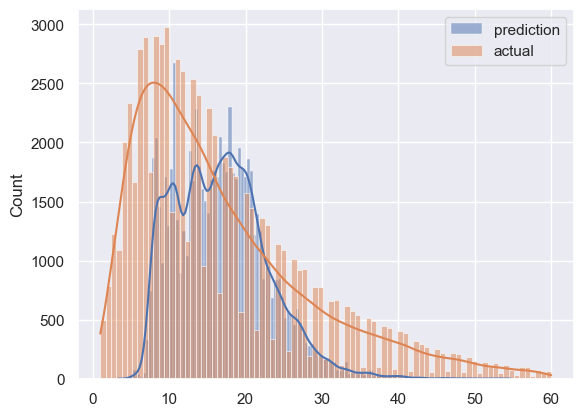

In [10]:
sns.histplot(y_pred, kde=True, label='prediction')
sns.histplot(y_train, kde=True, label='actual')

plt.legend()

In [11]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        green_taxi_trips = pd.read_csv(filename)

        green_taxi_trips['lpep_dropoff_datetime'] = pd.to_datetime(green_taxi_trips['lpep_dropoff_datetime'])
        green_taxi_trips['lpep_pickup_datetime'] = pd.to_datetime(green_taxi_trips['lpep_pickup_datetime'])
    elif filename.endswith('.parquet'):
        green_taxi_trips = pd.read_parquet(filename)

    green_taxi_trips['duration'] = green_taxi_trips['lpep_dropoff_datetime'] - green_taxi_trips['lpep_pickup_datetime']
    green_taxi_trips['duration'] = green_taxi_trips['duration'].apply(lambda td: td.total_seconds() / 60)

    green_taxi_trips = green_taxi_trips[(green_taxi_trips['duration'] >= 1) & (green_taxi_trips['duration'] <= 60)]

    categorical_vars = ['PULocationID', 'DOLocationID']
    green_taxi_trips[categorical_vars] = green_taxi_trips[categorical_vars].astype(str)

    return green_taxi_trips

In [12]:
df_train = read_dataframe(TRAIN_DATA_FILE_PATH)
df_val = read_dataframe(VAL_DATA_FILE_PATH)

In [13]:
len(df_train), len(df_val)

(73908, 61921)

In [14]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [15]:
categorical = ['PU_DO']  #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.75871521021275

In [22]:
with mlflow.start_run():
    mlflow.set_tag('username', 'jxareas')

    mlflow.log_param('train-data-file-path', TRAIN_DATA_FILE_PATH)
    mlflow.log_param('val-data-file-path', VAL_DATA_FILE_PATH)

    alpha = 0.01
    mlflow.log_param('alpha', alpha)

    lr = Lasso(alpha=alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric('rmse', rmse)